# Paddle 2.0 API 示例教程（CycleGAN）

作者：吕坤

日期：2020/10/24

## CycleGAN介绍
CycleGAN，即循环生成对抗网络，是一种用于图片风格迁移的模型。原来的图片风格迁移模型通过在两组一一匹配的图片进行上训练，来学习输入图片组与输出图片组的特征映射关系，从而实现将输入图片的特征迁移到输出图片上，比如将A组图片的斑马的条纹外观特征迁移到B组普通马匹图片上。但是，训练所要求的两组一一对应训练集图片往往难以获得。CycleGAN通过给GAN网络添加循环一致性损失（consistency loss）的方法打破了训练集图片数据的一一对应限制。
* 论文原文：[Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593.pdf)
* 论文原版代码：[https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* AI Studio 可执行项目地址：[https://aistudio.baidu.com/aistudio/projectdetail/1147248](https://aistudio.baidu.com/aistudio/projectdetail/1147248)

## 框架导入设置

In [ ]:
# # 解压 ai studio 数据集（首次执行后注释）
# !unzip -qa -d /home/aistudio/data/data10040/ /home/aistudio/data/data10040/horse2zebra.zip

In [ ]:
import paddle
from paddle.io import Dataset, DataLoader
import paddle.fluid as fluid
import numpy as np
import cv2
import random
import time
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=Warning) # 过滤报警信息

paddle.disable_static() # 设置框架使用动态图模式

BATCH_SIZE = 1
DATA_DIR = '/home/aistudio/data/data10040/horse2zebra/' # 设置训练集数据地址
# PLACE = fluid.CPUPlace() # 在cpu上训练
PLACE = fluid.CUDAPlace(0)  # 在gpu上训练

## 准备数据集

In [ ]:
from PIL import Image

# 处理图片数据：随机裁切、调整图片数据形状、归一化数据
def data_transform(img, output_size):
    h, w, _ = img.shape
    assert h == w and h >= output_size # check picture size

    # random crop
    margin = h - output_size
    left = random.randint(0, margin)
    top = random.randint(0, margin)
    img = img[top : top + output_size, left : left + output_size, :]

    # normalize
    img = img / 255. * 2. - 1.

    # from [H,W,C] to [C,H,W]
    img = np.transpose(img, (2, 0, 1))

    # data type
    img = img.astype('float32')
    
    return img

# 定义horse2zebra数据集对象
class H2ZDateset(Dataset):
    def __init__(self, data_dir, ab_set='a'):
        super(H2ZDateset, self).__init__()
        self.data_dir = data_dir
        if ab_set == 'a':
            self.pic_list = np.loadtxt(data_dir+'trainA.txt', dtype=np.str)
        elif ab_set == 'b':
            self.pic_list = np.loadtxt(data_dir+'trainB.txt', dtype=np.str)
    def __getitem__(self, idx):
        img_dir = self.data_dir+self.pic_list[idx]
        img = cv2.imread(img_dir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = data_transform(img, 224)
        return img
    def __len__(self):
        return self.pic_list.shape[0]

# 定义A组图片loader
h2zdateset_a = H2ZDateset(DATA_DIR, ab_set='a')
loader_a = DataLoader(h2zdateset_a, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=False, num_workers=0, use_shared_memory=False)

# 定义B组图片loader
h2zdateset_b = H2ZDateset(DATA_DIR, ab_set='b')
loader_b = DataLoader(h2zdateset_b, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=False, num_workers=0, use_shared_memory=False) 

# 打印读取图片数据的形状
data_a, data_b = next(loader_a())[0], next(loader_b())[0]
print('A组图片形状', data_a.shape, 'B组图片形状', data_b.shape)


A组图片形状 [1, 3, 224, 224] B组图片形状 [1, 3, 224, 224]


## 定义辅助功能函数

In [ ]:
from PIL import Image
import os

# 打开图片
def open_pic(file_name='./data/data10040/horse2zebra/testA/n02381460_1300.jpg'):
    img = Image.open(file_name).resize((256, 256), Image.BILINEAR)
    img = (np.array(img).astype('float32') / 255.0 - 0.5) / 0.5
    img = img.transpose((2, 0, 1))
    img = img.reshape((-1, img.shape[0], img.shape[1], img.shape[2]))
    return img

# 存储图片
def save_pics(pics, file_name='tmp', save_path='./output/pics/', save_root_path='./output/'):
    if not os.path.exists(save_root_path):
        os.makedirs(save_root_path)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for i in range(len(pics)):
        pics[i] = pics[i][0]
    pic = np.concatenate(tuple(pics), axis=2)
    pic = pic.transpose((1,2,0))
    pic = (pic + 1) / 2
    # plt.imshow(pic)
    pic = np.clip(pic * 256, 0, 255)
    img = Image.fromarray(pic.astype('uint8')).convert('RGB')
    img.save(save_path+file_name+'.jpg')
    
# 显示图片
def show_pics(pics):
    plt.figure(figsize=(3 * len(pics), 3), dpi=80)
    for i in range(len(pics)):
        pics[i] = (pics[i][0].transpose((1,2,0)) + 1) / 2
        plt.subplot(1, len(pics), i + 1)
        plt.imshow(pics[i])
        plt.xticks([])
        plt.yticks([])

# 图片缓存队列
class ImagePool(object):
    def __init__(self, pool_size=50):
        self.pool = []
        self.count = 0
        self.pool_size = pool_size

    def pool_image(self, image):
        return image
        image = image.numpy()
        rtn = ''
        if self.count < self.pool_size:
            self.pool.append(image)
            self.count += 1
            rtn = image
        else:
            p = np.random.rand()
            if p > 0.5:
                random_id = np.random.randint(0, self.pool_size - 1)
                temp = self.pool[random_id]
                self.pool[random_id] = image
                rtn = temp
            else:
                rtn = image
        return fluid.dygraph.to_variable(rtn)


## 查看读取的数据集图片

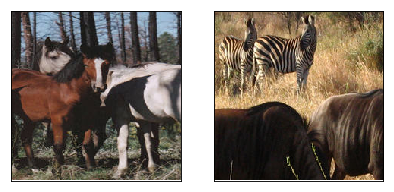

In [ ]:
show_pics([data_a.numpy(), data_b.numpy()])

## 定义判别器

In [ ]:
import paddle
import paddle.nn as nn
import numpy as np

# 定义基础的“卷积层+实例归一化”块
class ConvIN(nn.Layer):
    def __init__(self, num_channels, num_filters, filter_size, stride=1, padding=1, bias_attr=None, 
        weight_attr=None):
        super(ConvIN, self).__init__()
        model = [
            nn.Conv2D(num_channels, num_filters, filter_size, stride=stride, padding=padding, 
                bias_attr=bias_attr, weight_attr=weight_attr),
            nn.InstanceNorm2D(num_filters),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

# 定义CycleGAN的判别器
class Disc(nn.Layer):
    def __init__(self, weight_attr=nn.initializer.Normal(0., 0.02)):
        super(Disc, self).__init__()
        model = [
            ConvIN(3, 64, 4, stride=2, padding=1, bias_attr=True, weight_attr=weight_attr),
            ConvIN(64, 128, 4, stride=2, padding=1, bias_attr=False, weight_attr=weight_attr),
            ConvIN(128, 256, 4, stride=2, padding=1, bias_attr=False, weight_attr=weight_attr),
            ConvIN(256, 512, 4, stride=1, padding=1, bias_attr=False, weight_attr=weight_attr),
            nn.Conv2D(512, 1, 4, stride=1, padding=1, bias_attr=True, weight_attr=weight_attr)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)


## 测试判别器模块

In [ ]:
with paddle.fluid.dygraph.guard(PLACE):
    ci = ConvIN(3, 3, 3, weight_attr=nn.initializer.Normal(0., 0.02))
    logit = ci(paddle.to_tensor(data_a))
    print('ConvIN块输出的特征图形状：', logit.shape)

    d = Disc()
    logit = d(paddle.to_tensor(data_a))
    print('判别器输出的特征图形状：', logit.shape)



ConvIN块输出的特征图形状： [1, 3, 224, 224]
判别器输出的特征图形状： [1, 1, 26, 26]


## 定义生成器

In [ ]:
# 定义基础的“转置卷积层+实例归一化”块
class ConvTransIN(nn.Layer):
    def __init__(self, num_channels, num_filters, filter_size, stride=1, padding='same', padding_mode='constant', 
        bias_attr=None, weight_attr=None):
        super(ConvTransIN, self).__init__()
        model = [
            nn.Conv2DTranspose(num_channels, num_filters, filter_size, stride=stride, padding=padding, 
                bias_attr=bias_attr, weight_attr=weight_attr),
            nn.InstanceNorm2D(num_filters),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

# 定义残差块
class Residual(nn.Layer):
    def __init__(self, dim, bias_attr=None, weight_attr=None):
        super(Residual, self).__init__()
        model = [
            nn.Conv2D(dim, dim, 3, stride=1, padding=1, padding_mode='reflect', bias_attr=bias_attr, 
                weight_attr=weight_attr),
            nn.InstanceNorm2D(dim),
            nn.LeakyReLU(negative_slope=0.2),
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return x + self.model(x)

# 定义CycleGAN的生成器
class Gen(nn.Layer):
    def __init__(self, base_dim=64, residual_num=7, downup_layer=2, weight_attr=nn.initializer.Normal(0., 0.02)):
        super(Gen, self).__init__()
        model=[
            nn.Conv2D(3, base_dim, 7, stride=1, padding=3, padding_mode='reflect', bias_attr=False, 
                weight_attr=weight_attr),
            nn.InstanceNorm2D(base_dim),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        # 下采样块（down sampling）
        for i in range(downup_layer):
            model += [
                ConvIN(base_dim * 2 ** i, base_dim * 2 ** (i + 1), 3, stride=2, padding=1, bias_attr=False, 
                    weight_attr=weight_attr),
            ]
        # 残差块（residual blocks）
        for i in range(residual_num):
            model += [
                Residual(base_dim * 2 ** downup_layer, True, weight_attr=nn.initializer.Normal(0., 0.02))
            ]
        # 上采样块（up sampling）
        for i in range(downup_layer):
            model += [
                ConvTransIN(base_dim * 2 ** (downup_layer - i), base_dim * 2 ** (downup_layer - i - 1), 3, 
                    stride=2, padding='same', padding_mode='constant', bias_attr=False, weight_attr=weight_attr),
            ]
        model += [
            nn.Conv2D(base_dim, 3, 7, stride=1, padding=3, padding_mode='reflect', bias_attr=True, 
                weight_attr=nn.initializer.Normal(0., 0.02)),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)


## 测试生成器模块

In [ ]:
with paddle.fluid.dygraph.guard(PLACE):
    cti = ConvTransIN(3, 3, 3, stride=2, padding='same', padding_mode='constant', bias_attr=False, 
        weight_attr=nn.initializer.Normal(0., 0.02))
    logit = cti(paddle.to_tensor(data_a))
    print('ConvTransIN块输出的特征图形状：', logit.shape)

    r = Residual(3, True, weight_attr=nn.initializer.Normal(0., 0.02))
    logit = r(paddle.to_tensor(data_a))
    print('Residual块输出的特征图形状：', logit.shape)

    g = Gen()
    logit = g(paddle.to_tensor(data_a))
    print('生成器输出的特征图形状：', logit.shape)


ConvTransIN块输出的特征图形状： [1, 3, 448, 448]
Residual块输出的特征图形状： [1, 3, 224, 224]
生成器输出的特征图形状： [1, 3, 224, 224]


## 训练CycleGAN网络

In [ ]:
# 模型训练函数
def train(place, epoch_num=99999, adv_weight=1, cycle_weight=10, identity_weight=10, \
          load_model=False, model_path='./model/', model_path_bkp='./model_bkp/', \
          print_interval=1, max_step=5, model_bkp_interval=2000):
    with fluid.dygraph.guard(place):
        # 定义两对生成器、判别器对象
        g_a = Gen()
        g_b = Gen()
        d_a = Disc()
        d_b = Disc()

        # 定义数据读取器
        da = H2ZDateset(DATA_DIR, ab_set='a')
        reader_a = DataLoader(da, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=False, 
            num_workers=2)
        db = H2ZDateset(DATA_DIR, ab_set='b')
        reader_b = DataLoader(db, places=PLACE, shuffle=True, batch_size=BATCH_SIZE, drop_last=False, 
            num_workers=2)

        # 定义优化器
        g_a_optimizer = fluid.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameter_list=g_a.parameters())
        g_b_optimizer = fluid.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameter_list=g_b.parameters())
        d_a_optimizer = fluid.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameter_list=d_a.parameters())
        d_b_optimizer = fluid.optimizer.Adam(learning_rate=0.0002, beta1=0.5, beta2=0.999, parameter_list=d_b.parameters())

        # 定义图片缓存队列
        fa_pool, fb_pool = ImagePool(), ImagePool()

        # 定义总迭代次数为0
        total_step_num = np.array([0])

        # 加载存储的模型
        if load_model == True:
            ga_para, ga_opt = fluid.load_dygraph(model_path+'gen_b2a')
            gb_para, gb_opt = fluid.load_dygraph(model_path+'gen_a2b')
            da_para, da_opt = fluid.load_dygraph(model_path+'dis_ga')
            db_para, db_opt = fluid.load_dygraph(model_path+'dis_gb')
            g_a.load_dict(ga_para)
            g_a_optimizer.set_dict(ga_opt)
            g_b.load_dict(gb_para)
            g_b_optimizer.set_dict(gb_opt)
            d_a.load_dict(da_para)
            d_a_optimizer.set_dict(da_opt)
            d_b.load_dict(db_para)
            d_b_optimizer.set_dict(db_opt)
            total_step_num = np.load('./model/total_step_num.npy')
        
        # 定义本次训练开始时的迭代次数
        step = total_step_num[0]

        # 开始模型训练循环
        print('Start time :', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), 'start step:', step + 1)
        for epoch in range(epoch_num):
            for data_a, data_b in zip(reader_a, reader_b):
                step += 1

                # 设置模型为训练模式，针对bn、dropout等进行不同处理
                g_a.train()
                g_b.train()
                d_a.train()
                d_b.train()

                # 得到A、B组图片数据
                img_ra = paddle.to_tensor(data_a[0])
                img_rb = paddle.to_tensor(data_b[0])

                # 训练判别器DA
                d_loss_ra = fluid.layers.reduce_mean((d_a(img_ra.detach()) - 1) ** 2)
                d_loss_fa = fluid.layers.reduce_mean(d_a(fa_pool.pool_image(g_a(img_rb.detach()))) ** 2)
                da_loss = (d_loss_ra + d_loss_fa) * 0.5
                da_loss.backward() # 反向更新梯度
                d_a_optimizer.minimize(da_loss) # 更新模型权重
                d_a.clear_gradients() # 清除梯度

                # 训练判别器DB
                d_loss_rb = fluid.layers.reduce_mean((d_b(img_rb.detach()) - 1) ** 2)
                d_loss_fb = fluid.layers.reduce_mean(d_b(fb_pool.pool_image(g_b(img_ra.detach()))) ** 2)
                db_loss = (d_loss_rb + d_loss_fb) * 0.5
                db_loss.backward()
                d_b_optimizer.minimize(db_loss)
                d_b.clear_gradients()

                # 训练生成器GA
                ga_gan_loss = fluid.layers.reduce_mean((d_a(g_a(img_rb.detach())) - 1) ** 2)
                ga_cyc_loss = fluid.layers.reduce_mean(fluid.layers.abs(img_rb.detach() - g_b(g_a(img_rb.detach()))))
                ga_ide_loss = fluid.layers.reduce_mean(fluid.layers.abs(img_ra.detach() - g_a(img_ra.detach())))
                ga_loss = ga_gan_loss * adv_weight + ga_cyc_loss * cycle_weight + ga_ide_loss * identity_weight
                ga_loss.backward()
                g_a_optimizer.minimize(ga_loss)
                g_a.clear_gradients()

                # 训练生成器GB
                gb_gan_loss = fluid.layers.reduce_mean((d_b(g_b(img_ra.detach())) - 1) ** 2)
                gb_cyc_loss = fluid.layers.reduce_mean(fluid.layers.abs(img_ra.detach() - g_a(g_b(img_ra.detach()))))
                gb_ide_loss = fluid.layers.reduce_mean(fluid.layers.abs(img_rb.detach() - g_b(img_rb.detach())))
                gb_loss = gb_gan_loss * adv_weight + gb_cyc_loss * cycle_weight + gb_ide_loss * identity_weight
                gb_loss.backward()
                g_b_optimizer.minimize(gb_loss)
                g_b.clear_gradients()
                
                # 存储训练过程中生成的图片
                if step in range(1, 101):
                    pic_save_interval = 1
                elif step in range(101, 1001):
                    pic_save_interval = 10
                elif step in range(1001, 10001):
                    pic_save_interval = 100
                else:
                    pic_save_interval = 500
                if step % pic_save_interval == 0:
                    save_pics([img_ra.numpy(), g_b(img_ra).numpy(), g_a(g_b(img_ra)).numpy(), g_b(img_rb).numpy(), \
                               img_rb.numpy(), g_a(img_rb).numpy(), g_b(g_a(img_rb)).numpy(), g_a(img_ra).numpy()], \
                               str(step))
                    test_pic = open_pic()
                    test_pic_pp = fluid.dygraph.to_variable(test_pic)
                    save_pics([test_pic, g_b(test_pic_pp).numpy()], str(step), save_path='./output/pics_test/')

                # 打印训练过程中的loss值和生成的图片
                if step % print_interval == 0:
                    print([step], \
                          'DA:', da_loss.numpy(), \
                          'DB:', db_loss.numpy(), \
                          'GA:', ga_loss.numpy(), \
                          'GB:', gb_loss.numpy(), \
                          time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
                    show_pics([img_ra.numpy(), g_b(img_ra).numpy(), g_a(g_b(img_ra)).numpy(), g_b(img_rb).numpy()])
                    show_pics([img_rb.numpy(), g_a(img_rb).numpy(), g_b(g_a(img_rb)).numpy(), g_a(img_ra).numpy()])

                # 定期备份模型
                if step % model_bkp_interval == 0:
                    fluid.save_dygraph(g_a.state_dict(), model_path_bkp+'gen_b2a')
                    fluid.save_dygraph(g_a_optimizer.state_dict(), model_path_bkp+'gen_b2a')
                    fluid.save_dygraph(g_b.state_dict(), model_path_bkp+'gen_a2b')
                    fluid.save_dygraph(g_b_optimizer.state_dict(), model_path_bkp+'gen_a2b')
                    fluid.save_dygraph(d_a.state_dict(), model_path_bkp+'dis_ga')
                    fluid.save_dygraph(d_a_optimizer.state_dict(), model_path_bkp+'dis_ga')
                    fluid.save_dygraph(d_b.state_dict(), model_path_bkp+'dis_gb')
                    fluid.save_dygraph(d_b_optimizer.state_dict(), model_path_bkp+'dis_gb')
                    np.save(model_path_bkp+'total_step_num', np.array([step]))

                # 完成训练时存储模型
                if step >= max_step + total_step_num[0]:
                    fluid.save_dygraph(g_a.state_dict(), model_path+'gen_b2a')
                    fluid.save_dygraph(g_a_optimizer.state_dict(), model_path+'gen_b2a')
                    fluid.save_dygraph(g_b.state_dict(), model_path+'gen_a2b')
                    fluid.save_dygraph(g_b_optimizer.state_dict(), model_path+'gen_a2b')
                    fluid.save_dygraph(d_a.state_dict(), model_path+'dis_ga')
                    fluid.save_dygraph(d_a_optimizer.state_dict(), model_path+'dis_ga')
                    fluid.save_dygraph(d_b.state_dict(), model_path+'dis_gb')
                    fluid.save_dygraph(d_b_optimizer.state_dict(), model_path+'dis_gb')
                    np.save(model_path+'total_step_num', np.array([step]))
                    print('End time :', time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), 'End Step:', step)
                    return

# 从头训练
train(PLACE)

# 继续训练
# train(PLACE, print_interval=1, max_step=5, load_model=True)
# train(PLACE, print_interval=500, max_step=8000, load_model=True)


Start time : 2020-11-30 23:36:56 start step: 240001
[240500] DA: [0.09802376] DB: [0.10756996] GA: [2.396585] GB: [1.9313557] 2020-11-30 23:38:47
[241000] DA: [0.0487169] DB: [0.03832049] GA: [3.2354655] GB: [2.8926044] 2020-11-30 23:40:38


## 用训练好的模型进行预测

(1, 3, 224, 224) float32


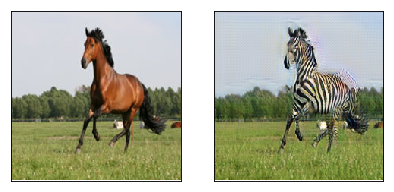

In [ ]:
def infer(img_path, place, model_path='./model/'):
    with fluid.dygraph.guard(place):
        # 定义生成器对象
        g_b = Gen()

        # 设置模型为训练模式，针对bn、dropout等进行不同处理
        g_b.eval()

        # 读取存储的模型
        gb_para, _ = fluid.load_dygraph(model_path+'gen_a2b')
        g_b.load_dict(gb_para)
     
        # 读取图片数据
        img_a = cv2.imread(img_path)
        img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
        img_a = data_transform(img_a, 224)
        img_a = paddle.to_tensor(np.array([img_a]))
        
        # 正向计算进行推理
        img_b = g_b(img_a)

        # 打印输出输入、输出图片
        print(img_a.numpy().shape, img_a.numpy().dtype)
        show_pics([img_a.numpy(), img_b.numpy()])

infer('./data/data10040/horse2zebra/testA/n02381460_1300.jpg', PLACE)

